In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import torch.nn.utils.spectral_norm as spectral_norm

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Directories
image_dir = "celebA/celeba/img_align_celeba"
os.makedirs("gan_outputs", exist_ok=True)

In [ ]:
# Hyperparameters
z_dim = 100
lr = 2e-4
batch_size = 64
n_epochs = 50
patience = 5

In [5]:
# Transformations
transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
# Dataset and splits
full_dataset = datasets.ImageFolder(root=image_dir, transform=transform)
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size  # ensure the sum matches exactly

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, features_g=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_g * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 8, features_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 4, features_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 2, features_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, img_channels=3, features_d=64):
        super().__init__()
        self.net = nn.Sequential(
            spectral_norm(nn.Conv2d(img_channels, features_d, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(features_d, features_d * 2, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(features_d * 2, features_d * 4, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(features_d * 4, features_d * 8, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(features_d * 8, 1, 4, 1, 0)),
        )

    def forward(self, img):
        return self.net(img).view(-1)


In [8]:
# Initialize models and optimizers
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

In [9]:
criterion = nn.BCEWithLogitsLoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

In [10]:
best_val_loss = float("inf")
epochs_no_improve = 0
train_losses = []
val_losses = []

# Training loop
for epoch in range(n_epochs):
    G.train()
    D.train()
    running_loss_G = 0.0
    running_loss_D = 0.0

    print(f"Epoch [{epoch+1}/{n_epochs}]")
    for real_imgs, _ in tqdm(train_loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # Train Discriminator
        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_imgs = G(z).detach()
        D_real = D(real_imgs)
        D_fake = D(fake_imgs)
        loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_imgs = G(z)
        D_fake = D(fake_imgs)
        loss_G = criterion(D_fake, real_labels)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        running_loss_D += loss_D.item()
        running_loss_G += loss_G.item()

    avg_train_loss_G = running_loss_G / len(train_loader)
    avg_train_loss_D = running_loss_D / len(train_loader)
    train_losses.append((avg_train_loss_D, avg_train_loss_G))

    # Validation step
    G.eval()
    D.eval()
    val_loss_D = 0.0
    val_loss_G = 0.0
    with torch.no_grad():
        for real_imgs, _ in val_loader:
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)
            real_labels = torch.ones(batch_size, device=device)
            fake_labels = torch.zeros(batch_size, device=device)

            # Discriminator validation
            z = torch.randn(batch_size, z_dim, 1, 1, device=device)
            fake_imgs = G(z)
            D_real = D(real_imgs)
            D_fake = D(fake_imgs)
            loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

            # Generator validation
            z = torch.randn(batch_size, z_dim, 1, 1, device=device)
            fake_imgs = G(z)
            D_fake = D(fake_imgs)
            loss_G = criterion(D_fake, real_labels)

            val_loss_D += loss_D.item()
            val_loss_G += loss_G.item()

    avg_val_loss_D = val_loss_D / len(val_loader)
    avg_val_loss_G = val_loss_G / len(val_loader)
    val_losses.append((avg_val_loss_D, avg_val_loss_G))

    print(f"Train Loss D: {avg_train_loss_D:.4f}, G: {avg_train_loss_G:.4f} | Val Loss D: {avg_val_loss_D:.4f}, G: {avg_val_loss_G:.4f}")

    # Early stopping check
    if avg_val_loss_D + avg_val_loss_G < best_val_loss:
        best_val_loss = avg_val_loss_D + avg_val_loss_G
        epochs_no_improve = 0
        torch.save(G.state_dict(), "gan_outputs/best_generator.pth")
        torch.save(D.state_dict(), "gan_outputs/best_discriminator.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

    # Save sample images
    with torch.no_grad():
        fake_imgs = G(fixed_noise).detach().cpu()
        grid = make_grid(fake_imgs, padding=2, normalize=True)
        save_image(grid, f"gan_outputs/epoch_{epoch+1}.png")

Epoch [1/50]



  0%|          | 0/55 [00:00<?, ?it/s]


  2%|▏         | 1/55 [00:08<07:27,  8.28s/it]


  4%|▎         | 2/55 [00:13<05:41,  6.45s/it]


  5%|▌         | 3/55 [00:18<05:05,  5.88s/it]


  7%|▋         | 4/55 [00:23<04:42,  5.53s/it]


  9%|▉         | 5/55 [00:28<04:24,  5.29s/it]


 11%|█         | 6/55 [00:34<04:24,  5.41s/it]


 13%|█▎        | 7/55 [00:39<04:15,  5.33s/it]


 15%|█▍        | 8/55 [00:44<04:08,  5.28s/it]


 16%|█▋        | 9/55 [00:50<04:08,  5.41s/it]


 18%|█▊        | 10/55 [00:55<04:06,  5.47s/it]


 20%|██        | 11/55 [01:02<04:12,  5.75s/it]


 22%|██▏       | 12/55 [01:09<04:21,  6.09s/it]


 24%|██▎       | 13/55 [01:15<04:26,  6.33s/it]


 25%|██▌       | 14/55 [01:22<04:28,  6.55s/it]


 27%|██▋       | 15/55 [01:29<04:27,  6.69s/it]


 29%|██▉       | 16/55 [01:36<04:23,  6.75s/it]


 31%|███       | 17/55 [01:44<04:21,  6.88s/it]


 33%|███▎      | 18/55 [01:51<04:16,  6.94s/it]


 35%|███▍      | 19/55 [01:56<03:57,  6.60s/it]


 36%|███▋      | 20/55 [02:03<03:53,  6.68s/it]


 38%|███▊      | 21/55 [02:11<03:54,  6.91s/it]


 40%|████      | 22/55 [02:18<03:46,  6.87s/it]


 42%|████▏     | 23/55 [02:23<03:23,  6.35s/it]


 44%|████▎     | 24/55 [02:28<03:11,  6.17s/it]


 45%|████▌     | 25/55 [02:36<03:14,  6.47s/it]


 47%|████▋     | 26/55 [02:43<03:14,  6.71s/it]


 49%|████▉     | 27/55 [02:50<03:12,  6.87s/it]


 51%|█████     | 28/55 [02:57<03:02,  6.76s/it]


 53%|█████▎    | 29/55 [03:02<02:48,  6.47s/it]


 55%|█████▍    | 30/55 [03:07<02:29,  5.96s/it]


 56%|█████▋    | 31/55 [03:12<02:15,  5.66s/it]


 58%|█████▊    | 32/55 [03:17<02:03,  5.36s/it]


 60%|██████    | 33/55 [03:22<01:58,  5.40s/it]


 62%|██████▏   | 34/55 [03:28<01:55,  5.52s/it]


 64%|██████▎   | 35/55 [03:33<01:45,  5.29s/it]


 65%|██████▌   | 36/55 [03:38<01:40,  5.28s/it]


 67%|██████▋   | 37/55 [03:43<01:34,  5.25s/it]


 69%|██████▉   | 38/55 [03:50<01:35,  5.59s/it]


 71%|███████   | 39/55 [03:56<01:33,  5.83s/it]


 73%|███████▎  | 40/55 [04:01<01:21,  5.44s/it]


 75%|███████▍  | 41/55 [04:06<01:14,  5.32s/it]


 76%|███████▋  | 42/55 [04:12<01:12,  5.61s/it]


 78%|███████▊  | 43/55 [04:18<01:07,  5.65s/it]


 80%|████████  | 44/55 [04:24<01:04,  5.90s/it]


 82%|████████▏ | 45/55 [04:31<01:00,  6.05s/it]


 84%|████████▎ | 46/55 [04:37<00:56,  6.24s/it]


 85%|████████▌ | 47/55 [04:44<00:50,  6.31s/it]


 87%|████████▋ | 48/55 [04:50<00:45,  6.45s/it]


 89%|████████▉ | 49/55 [04:58<00:40,  6.67s/it]


 91%|█████████ | 50/55 [05:04<00:32,  6.45s/it]


 93%|█████████▎| 51/55 [05:11<00:26,  6.72s/it]


 95%|█████████▍| 52/55 [05:17<00:19,  6.61s/it]


 96%|█████████▋| 53/55 [05:24<00:13,  6.58s/it]


 98%|█████████▊| 54/55 [05:30<00:06,  6.37s/it]


100%|██████████| 55/55 [05:30<00:00,  4.52s/it]


100%|██████████| 55/55 [05:30<00:00,  6.01s/it]

Train Loss D: 0.4224, G: 3.3618 | Val Loss D: 0.4971, G: 1.0467
Epoch [2/50]



  0%|          | 0/55 [00:00<?, ?it/s]


  2%|▏         | 1/55 [00:05<04:37,  5.14s/it]


  4%|▎         | 2/55 [00:10<04:51,  5.50s/it]


  5%|▌         | 3/55 [00:18<05:26,  6.28s/it]


  7%|▋         | 4/55 [00:23<04:59,  5.88s/it]


  9%|▉         | 5/55 [00:28<04:47,  5.74s/it]


 11%|█         | 6/55 [00:34<04:39,  5.70s/it]


 13%|█▎        | 7/55 [00:40<04:38,  5.80s/it]


 15%|█▍        | 8/55 [00:47<04:44,  6.06s/it]


 16%|█▋        | 9/55 [00:53<04:39,  6.08s/it]


 18%|█▊        | 10/55 [00:59<04:32,  6.05s/it]


 20%|██        | 11/55 [01:06<04:37,  6.30s/it]


 22%|██▏       | 12/55 [01:12<04:30,  6.30s/it]


 24%|██▎       | 13/55 [01:19<04:33,  6.51s/it]


 25%|██▌       | 14/55 [01:25<04:22,  6.41s/it]


 27%|██▋       | 15/55 [01:31<04:06,  6.17s/it]


 29%|██▉       | 16/55 [01:35<03:41,  5.67s/it]


 31%|███       | 17/55 [01:40<03:28,  5.48s/it]


 33%|███▎      | 18/55 [01:45<03:10,  5.14s/it]


 35%|███▍      | 19/55 [01:49<03:00,  5.01s/it]


 36%|███▋      | 20/55 [01:54<02:50,  4.87s/it]


 38%|███▊      | 21/55 [01:59<02:44,  4.84s/it]


 40%|████      | 22/55 [02:06<03:08,  5.70s/it]


 42%|████▏     | 23/55 [02:11<02:54,  5.45s/it]


 44%|████▎     | 24/55 [02:18<03:00,  5.82s/it]


 45%|████▌     | 25/55 [02:22<02:42,  5.40s/it]


 47%|████▋     | 26/55 [02:27<02:34,  5.32s/it]


 49%|████▉     | 27/55 [02:32<02:24,  5.16s/it]


 51%|█████     | 28/55 [02:38<02:22,  5.27s/it]


 53%|█████▎    | 29/55 [02:43<02:18,  5.34s/it]


 55%|█████▍    | 30/55 [02:49<02:15,  5.41s/it]


 56%|█████▋    | 31/55 [02:53<02:04,  5.17s/it]


 58%|█████▊    | 32/55 [02:58<01:54,  4.96s/it]


 60%|██████    | 33/55 [03:03<01:50,  5.04s/it]


 62%|██████▏   | 34/55 [03:08<01:48,  5.14s/it]


 64%|██████▎   | 35/55 [03:14<01:44,  5.21s/it]


 65%|██████▌   | 36/55 [03:19<01:39,  5.26s/it]


 67%|██████▋   | 37/55 [03:24<01:30,  5.02s/it]


 69%|██████▉   | 38/55 [03:28<01:20,  4.71s/it]


 71%|███████   | 39/55 [03:32<01:11,  4.49s/it]


 73%|███████▎  | 40/55 [03:36<01:04,  4.33s/it]


 75%|███████▍  | 41/55 [03:41<01:03,  4.52s/it]


 76%|███████▋  | 42/55 [03:45<00:56,  4.35s/it]


 78%|███████▊  | 43/55 [03:49<00:53,  4.42s/it]


 80%|████████  | 44/55 [03:54<00:50,  4.58s/it]


 82%|████████▏ | 45/55 [03:59<00:45,  4.57s/it]


 84%|████████▎ | 46/55 [04:03<00:39,  4.40s/it]


 85%|████████▌ | 47/55 [04:09<00:39,  4.94s/it]


 87%|████████▋ | 48/55 [04:16<00:38,  5.55s/it]


 89%|████████▉ | 49/55 [04:24<00:38,  6.41s/it]


 91%|█████████ | 50/55 [04:31<00:32,  6.53s/it]


 93%|█████████▎| 51/55 [04:35<00:23,  5.86s/it]


 95%|█████████▍| 52/55 [04:44<00:19,  6.56s/it]


 96%|█████████▋| 53/55 [04:50<00:12,  6.44s/it]


 98%|█████████▊| 54/55 [04:57<00:06,  6.70s/it]


100%|██████████| 55/55 [04:57<00:00,  4.73s/it]


100%|██████████| 55/55 [04:57<00:00,  5.41s/it]

Train Loss D: 1.1160, G: 1.5545 | Val Loss D: 1.2387, G: 0.8053
Epoch [3/50]



  0%|          | 0/55 [00:00<?, ?it/s]


  2%|▏         | 1/55 [00:07<06:37,  7.35s/it]


  4%|▎         | 2/55 [00:12<05:14,  5.94s/it]


  5%|▌         | 3/55 [00:19<05:43,  6.61s/it]


  7%|▋         | 4/55 [00:26<05:33,  6.53s/it]


  9%|▉         | 5/55 [00:30<04:56,  5.93s/it]


 11%|█         | 6/55 [00:38<05:15,  6.44s/it]


 13%|█▎        | 7/55 [00:44<05:09,  6.45s/it]


 15%|█▍        | 8/55 [00:51<05:09,  6.58s/it]


 16%|█▋        | 9/55 [00:59<05:13,  6.82s/it]


 18%|█▊        | 10/55 [01:06<05:09,  6.87s/it]


 20%|██        | 11/55 [01:12<04:54,  6.69s/it]


 22%|██▏       | 12/55 [01:18<04:41,  6.54s/it]


 24%|██▎       | 13/55 [01:25<04:39,  6.66s/it]


 25%|██▌       | 14/55 [01:32<04:32,  6.64s/it]


 27%|██▋       | 15/55 [01:36<04:01,  6.04s/it]


 29%|██▉       | 16/55 [01:40<03:29,  5.38s/it]


 31%|███       | 17/55 [01:44<03:05,  4.88s/it]


 33%|███▎      | 18/55 [01:48<02:47,  4.54s/it]


 35%|███▍      | 19/55 [01:51<02:36,  4.34s/it]


 36%|███▋      | 20/55 [01:56<02:31,  4.34s/it]


 38%|███▊      | 21/55 [02:01<02:32,  4.49s/it]


 40%|████      | 22/55 [02:05<02:31,  4.58s/it]


 42%|████▏     | 23/55 [02:13<02:55,  5.48s/it]


 44%|████▎     | 24/55 [02:20<03:07,  6.04s/it]


 45%|████▌     | 25/55 [02:25<02:48,  5.62s/it]


 47%|████▋     | 26/55 [02:30<02:36,  5.38s/it]


 49%|████▉     | 27/55 [02:37<02:44,  5.86s/it]


 51%|█████     | 28/55 [02:40<02:20,  5.20s/it]


 53%|█████▎    | 29/55 [02:45<02:12,  5.09s/it]


 55%|█████▍    | 30/55 [02:50<02:05,  5.02s/it]


 56%|█████▋    | 31/55 [02:56<02:04,  5.18s/it]


 58%|█████▊    | 32/55 [03:03<02:12,  5.77s/it]


 60%|██████    | 33/55 [03:10<02:17,  6.25s/it]


 62%|██████▏   | 34/55 [03:17<02:16,  6.50s/it]


 64%|██████▎   | 35/55 [03:22<02:02,  6.11s/it]


 65%|██████▌   | 36/55 [03:29<01:57,  6.17s/it]


 67%|██████▋   | 37/55 [03:35<01:51,  6.17s/it]


 69%|██████▉   | 38/55 [03:41<01:43,  6.10s/it]


 71%|███████   | 39/55 [03:44<01:22,  5.17s/it]


 73%|███████▎  | 40/55 [03:47<01:08,  4.54s/it]


 75%|███████▍  | 41/55 [03:50<00:58,  4.15s/it]


 76%|███████▋  | 42/55 [03:53<00:49,  3.83s/it]


 78%|███████▊  | 43/55 [03:56<00:43,  3.60s/it]


 80%|████████  | 44/55 [03:59<00:37,  3.44s/it]


 82%|████████▏ | 45/55 [04:02<00:33,  3.33s/it]


 84%|████████▎ | 46/55 [04:06<00:29,  3.25s/it]


 85%|████████▌ | 47/55 [04:08<00:25,  3.16s/it]


 87%|████████▋ | 48/55 [04:16<00:31,  4.43s/it]


 89%|████████▉ | 49/55 [04:22<00:28,  4.83s/it]


 91%|█████████ | 50/55 [04:28<00:27,  5.41s/it]


 93%|█████████▎| 51/55 [04:35<00:23,  5.87s/it]


 95%|█████████▍| 52/55 [04:43<00:19,  6.36s/it]


 96%|█████████▋| 53/55 [04:50<00:13,  6.71s/it]


 98%|█████████▊| 54/55 [04:58<00:07,  7.01s/it]


100%|██████████| 55/55 [04:58<00:00,  4.98s/it]


100%|██████████| 55/55 [04:58<00:00,  5.43s/it]

Train Loss D: 1.2031, G: 1.1208 | Val Loss D: 1.2436, G: 1.1374
Epoch [4/50]



  0%|          | 0/55 [00:00<?, ?it/s]


  2%|▏         | 1/55 [00:04<03:48,  4.24s/it]


  4%|▎         | 2/55 [00:10<04:57,  5.62s/it]


  5%|▌         | 3/55 [00:17<05:23,  6.21s/it]


  7%|▋         | 4/55 [00:25<05:45,  6.77s/it]


  9%|▉         | 5/55 [00:32<05:48,  6.98s/it]


 11%|█         | 6/55 [00:40<05:54,  7.23s/it]


 13%|█▎        | 7/55 [00:46<05:33,  6.94s/it]


 15%|█▍        | 8/55 [00:54<05:32,  7.06s/it]


 16%|█▋        | 9/55 [01:01<05:32,  7.22s/it]


 18%|█▊        | 10/55 [01:07<05:07,  6.84s/it]


 20%|██        | 11/55 [01:14<04:55,  6.71s/it]


 22%|██▏       | 12/55 [01:21<04:57,  6.93s/it]


 24%|██▎       | 13/55 [01:28<04:53,  6.98s/it]


 25%|██▌       | 14/55 [01:32<04:13,  6.17s/it]


 27%|██▋       | 15/55 [01:36<03:32,  5.32s/it]


 29%|██▉       | 16/55 [01:39<03:02,  4.67s/it]


 31%|███       | 17/55 [01:42<02:40,  4.24s/it]


 33%|███▎      | 18/55 [01:45<02:25,  3.93s/it]


 35%|███▍      | 19/55 [01:48<02:13,  3.70s/it]


 36%|███▋      | 20/55 [01:52<02:03,  3.53s/it]


 38%|███▊      | 21/55 [01:55<01:55,  3.39s/it]


 40%|████      | 22/55 [01:58<01:48,  3.29s/it]


 42%|████▏     | 23/55 [02:01<01:43,  3.23s/it]


 44%|████▎     | 24/55 [02:05<01:51,  3.61s/it]


 45%|████▌     | 25/55 [02:08<01:43,  3.46s/it]


 47%|████▋     | 26/55 [02:14<01:55,  3.97s/it]


 49%|████▉     | 27/55 [02:19<02:00,  4.30s/it]


 51%|█████     | 28/55 [02:24<02:01,  4.49s/it]


 53%|█████▎    | 29/55 [02:29<02:04,  4.78s/it]


 55%|█████▍    | 30/55 [02:34<01:59,  4.77s/it]


 56%|█████▋    | 31/55 [02:39<01:54,  4.76s/it]


 58%|█████▊    | 32/55 [02:44<01:52,  4.89s/it]


 60%|██████    | 33/55 [02:51<02:02,  5.57s/it]


 62%|██████▏   | 34/55 [02:57<01:58,  5.64s/it]


 64%|██████▎   | 35/55 [03:03<01:55,  5.79s/it]


 65%|██████▌   | 36/55 [03:09<01:50,  5.80s/it]


 67%|██████▋   | 37/55 [03:14<01:41,  5.62s/it]


 69%|██████▉   | 38/55 [03:20<01:36,  5.69s/it]


 71%|███████   | 39/55 [03:26<01:32,  5.78s/it]


 73%|███████▎  | 40/55 [03:31<01:24,  5.64s/it]


 75%|███████▍  | 41/55 [03:35<01:13,  5.24s/it]


 76%|███████▋  | 42/55 [03:39<01:03,  4.87s/it]


 78%|███████▊  | 43/55 [03:43<00:52,  4.36s/it]


 80%|████████  | 44/55 [03:46<00:43,  4.00s/it]


 82%|████████▏ | 45/55 [03:49<00:37,  3.75s/it]


 84%|████████▎ | 46/55 [03:52<00:31,  3.55s/it]


 85%|████████▌ | 47/55 [03:55<00:27,  3.43s/it]


 87%|████████▋ | 48/55 [03:58<00:23,  3.34s/it]


 89%|████████▉ | 49/55 [04:02<00:20,  3.39s/it]


 91%|█████████ | 50/55 [04:06<00:17,  3.55s/it]


 93%|█████████▎| 51/55 [04:11<00:16,  4.20s/it]


 95%|█████████▍| 52/55 [04:16<00:12,  4.30s/it]


 96%|█████████▋| 53/55 [04:21<00:09,  4.59s/it]


 98%|█████████▊| 54/55 [04:26<00:04,  4.72s/it]


100%|██████████| 55/55 [04:26<00:00,  3.35s/it]


100%|██████████| 55/55 [04:26<00:00,  4.85s/it]

Train Loss D: 1.2750, G: 0.9995 | Val Loss D: 1.3156, G: 0.7863
Epoch [5/50]



  0%|          | 0/55 [00:00<?, ?it/s]


  2%|▏         | 1/55 [00:03<03:22,  3.76s/it]


  4%|▎         | 2/55 [00:07<03:15,  3.69s/it]


  5%|▌         | 3/55 [00:10<03:07,  3.60s/it]


  7%|▋         | 4/55 [00:14<03:09,  3.71s/it]


  9%|▉         | 5/55 [00:21<03:59,  4.78s/it]


 11%|█         | 6/55 [00:28<04:29,  5.50s/it]


 13%|█▎        | 7/55 [00:33<04:23,  5.49s/it]


 15%|█▍        | 8/55 [00:40<04:30,  5.75s/it]


 16%|█▋        | 9/55 [00:46<04:31,  5.89s/it]


 18%|█▊        | 10/55 [00:53<04:47,  6.39s/it]


 20%|██        | 11/55 [00:59<04:34,  6.24s/it]


 22%|██▏       | 12/55 [01:02<03:47,  5.30s/it]


 24%|██▎       | 13/55 [01:09<03:54,  5.59s/it]


 25%|██▌       | 14/55 [01:15<03:54,  5.73s/it]


 27%|██▋       | 15/55 [01:20<03:46,  5.67s/it]


 29%|██▉       | 16/55 [01:25<03:31,  5.43s/it]


 31%|███       | 17/55 [01:30<03:14,  5.13s/it]


 33%|███▎      | 18/55 [01:34<03:06,  5.04s/it]


 35%|███▍      | 19/55 [01:39<02:57,  4.92s/it]


 36%|███▋      | 20/55 [01:44<02:50,  4.88s/it]


 38%|███▊      | 21/55 [01:49<02:47,  4.93s/it]


 40%|████      | 22/55 [01:55<02:50,  5.16s/it]


 42%|████▏     | 23/55 [02:01<02:57,  5.56s/it]


 44%|████▎     | 24/55 [02:04<02:29,  4.84s/it]


 45%|████▌     | 25/55 [02:07<02:09,  4.31s/it]


 47%|████▋     | 26/55 [02:10<01:54,  3.95s/it]


 49%|████▉     | 27/55 [02:14<01:43,  3.71s/it]


 51%|█████     | 28/55 [02:17<01:36,  3.57s/it]


 53%|█████▎    | 29/55 [02:20<01:29,  3.44s/it]


 55%|█████▍    | 30/55 [02:23<01:23,  3.36s/it]


 56%|█████▋    | 31/55 [02:26<01:20,  3.36s/it]


 58%|█████▊    | 32/55 [02:32<01:31,  3.98s/it]


 60%|██████    | 33/55 [02:37<01:35,  4.33s/it]


 62%|██████▏   | 34/55 [02:42<01:32,  4.43s/it]


 64%|██████▎   | 35/55 [02:46<01:30,  4.50s/it]


 65%|██████▌   | 36/55 [02:51<01:26,  4.56s/it]


 67%|██████▋   | 37/55 [02:55<01:17,  4.30s/it]


 69%|██████▉   | 38/55 [03:00<01:16,  4.52s/it]


 71%|███████   | 39/55 [03:04<01:09,  4.36s/it]


 73%|███████▎  | 40/55 [03:07<01:01,  4.12s/it]


 75%|███████▍  | 41/55 [03:13<01:04,  4.58s/it]


 76%|███████▋  | 42/55 [03:19<01:05,  5.00s/it]


 78%|███████▊  | 43/55 [03:24<01:01,  5.11s/it]


 80%|████████  | 44/55 [03:29<00:56,  5.12s/it]


 82%|████████▏ | 45/55 [03:35<00:52,  5.26s/it]


 84%|████████▎ | 46/55 [03:40<00:45,  5.04s/it]


 85%|████████▌ | 47/55 [03:45<00:41,  5.19s/it]


 87%|████████▋ | 48/55 [03:51<00:38,  5.43s/it]


 89%|████████▉ | 49/55 [03:57<00:32,  5.43s/it]


 91%|█████████ | 50/55 [04:04<00:29,  5.90s/it]


 93%|█████████▎| 51/55 [04:07<00:20,  5.04s/it]


 95%|█████████▍| 52/55 [04:10<00:13,  4.47s/it]


 96%|█████████▋| 53/55 [04:13<00:08,  4.07s/it]


 98%|█████████▊| 54/55 [04:16<00:03,  3.78s/it]


100%|██████████| 55/55 [04:16<00:00,  2.68s/it]


100%|██████████| 55/55 [04:16<00:00,  4.66s/it]

Train Loss D: 1.2752, G: 0.9671 | Val Loss D: 1.3226, G: 0.7563
Epoch [6/50]



  0%|          | 0/55 [00:00<?, ?it/s]


  2%|▏         | 1/55 [00:05<05:20,  5.94s/it]


  4%|▎         | 2/55 [00:12<05:29,  6.21s/it]


  5%|▌         | 3/55 [00:17<05:09,  5.94s/it]


  7%|▋         | 4/55 [00:24<05:11,  6.10s/it]


  9%|▉         | 5/55 [00:30<05:05,  6.11s/it]


 11%|█         | 6/55 [00:37<05:10,  6.34s/it]


 13%|█▎        | 7/55 [00:43<04:59,  6.23s/it]


 15%|█▍        | 8/55 [00:47<04:30,  5.76s/it]


 16%|█▋        | 9/55 [00:53<04:19,  5.64s/it]


 18%|█▊        | 10/55 [00:57<03:57,  5.28s/it]


 20%|██        | 11/55 [01:03<04:01,  5.50s/it]


 22%|██▏       | 12/55 [01:08<03:49,  5.33s/it]


 24%|██▎       | 13/55 [01:14<03:45,  5.36s/it]


 25%|██▌       | 14/55 [01:20<03:49,  5.59s/it]


 27%|██▋       | 15/55 [01:27<04:06,  6.17s/it]


 29%|██▉       | 16/55 [01:33<03:49,  5.87s/it]


 31%|███       | 17/55 [01:38<03:37,  5.73s/it]


 33%|███▎      | 18/55 [01:43<03:24,  5.53s/it]


 35%|███▍      | 19/55 [01:48<03:12,  5.34s/it]


 36%|███▋      | 20/55 [01:53<03:02,  5.22s/it]


 38%|███▊      | 21/55 [01:56<02:35,  4.59s/it]


 40%|████      | 22/55 [01:59<02:18,  4.20s/it]


 42%|████▏     | 23/55 [02:04<02:18,  4.32s/it]


 44%|████▎     | 24/55 [02:07<02:02,  3.97s/it]


 45%|████▌     | 25/55 [02:13<02:18,  4.63s/it]


 47%|████▋     | 26/55 [02:21<02:38,  5.47s/it]


 49%|████▉     | 27/55 [02:28<02:52,  6.15s/it]


 51%|█████     | 28/55 [02:36<02:57,  6.58s/it]


 53%|█████▎    | 29/55 [02:41<02:43,  6.28s/it]


 55%|█████▍    | 30/55 [02:48<02:39,  6.38s/it]


 56%|█████▋    | 31/55 [02:54<02:31,  6.32s/it]


 58%|█████▊    | 32/55 [02:57<02:03,  5.35s/it]


 60%|██████    | 33/55 [03:00<01:42,  4.68s/it]


 62%|██████▏   | 34/55 [03:04<01:28,  4.20s/it]


 64%|██████▎   | 35/55 [03:07<01:17,  3.87s/it]


 65%|██████▌   | 36/55 [03:10<01:09,  3.63s/it]


 67%|██████▋   | 37/55 [03:13<01:04,  3.61s/it]


 69%|██████▉   | 38/55 [03:18<01:06,  3.92s/it]


 71%|███████   | 39/55 [03:25<01:16,  4.81s/it]


 73%|███████▎  | 40/55 [03:31<01:17,  5.19s/it]


 75%|███████▍  | 41/55 [03:38<01:20,  5.78s/it]


 76%|███████▋  | 42/55 [03:44<01:15,  5.84s/it]


 78%|███████▊  | 43/55 [03:49<01:06,  5.51s/it]


 80%|████████  | 44/55 [03:54<00:59,  5.39s/it]


 82%|████████▏ | 45/55 [03:58<00:49,  4.92s/it]


 84%|████████▎ | 46/55 [04:01<00:39,  4.39s/it]


 85%|████████▌ | 47/55 [04:04<00:32,  4.01s/it]


 87%|████████▋ | 48/55 [04:07<00:26,  3.79s/it]


 89%|████████▉ | 49/55 [04:15<00:29,  4.88s/it]


 91%|█████████ | 50/55 [04:20<00:24,  4.94s/it]


 93%|█████████▎| 51/55 [04:24<00:18,  4.67s/it]


 95%|█████████▍| 52/55 [04:28<00:14,  4.67s/it]


 96%|█████████▋| 53/55 [04:33<00:09,  4.71s/it]


 98%|█████████▊| 54/55 [04:39<00:04,  4.92s/it]


100%|██████████| 55/55 [04:39<00:00,  3.48s/it]


100%|██████████| 55/55 [04:39<00:00,  5.08s/it]

Train Loss D: 1.2776, G: 0.9667 | Val Loss D: 1.3287, G: 1.0929
Early stopping triggered!


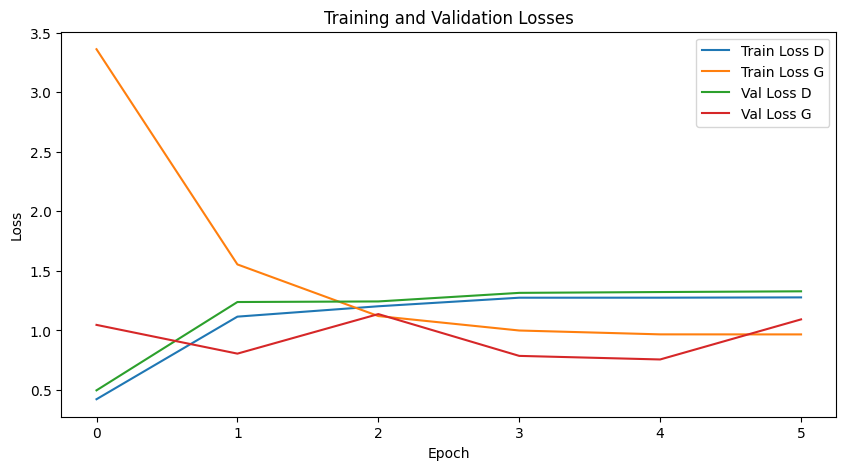

In [11]:
# Plot losses
train_loss_D, train_loss_G = zip(*train_losses)
val_loss_D, val_loss_G = zip(*val_losses)

plt.figure(figsize=(10, 5))
plt.plot(train_loss_D, label="Train Loss D")
plt.plot(train_loss_G, label="Train Loss G")
plt.plot(val_loss_D, label="Val Loss D")
plt.plot(val_loss_G, label="Val Loss G")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Losses")
plt.savefig("gan_outputs/loss_plot.png")
plt.show()


In [12]:
# Generate final images using best model
G.load_state_dict(torch.load("gan_outputs/best_generator.pth"))
G.eval()
with torch.no_grad():
    final_noise = torch.randn(64, z_dim, 1, 1, device=device)
    generated_imgs = G(final_noise)
    save_image(make_grid(generated_imgs, normalize=True), "gan_outputs/final_generated.png")